<a href="https://colab.research.google.com/github/techshot25/fashion-mnist-dnn/blob/master/DNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarking Fashion-MNIST with Deep Neural Nets

---

By Ali Shannon (aa3dc@virginia.edu)

### Part of CS 4501 Machine Learning - Department of Computer Science - University of Virginia
"The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others." - **Zalando Research, Github Repo.**"

Fashion-MNIST is a dataset from the Zalando's article. Each example is a 28x28 grayscale image, associated with a label from 10 classes. They intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

![Here's an example how the data looks (each class takes three-rows):](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

In this project, I will attempt to benchmark the Fashion-MNIST using Neural Networks. I will use it to train some neural networks on TensorFlow and predict the final output of 10 classes. 


In [0]:
# libraries needed
import numpy as np
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) #reduce annoying warning messages
from functools import partial
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

---
## 1. PRE-PROCESSING THE DATA

Loading fashion MNIST directly from Tensorflow. Partitioning the dataset and doing minimal preprocessing since the data is not raw.

Images are 28 x 28 pixels and they are labelled according to the clothing item represented in the picture, see the demonsration below

In [6]:
# Your code goes here for this section.
fmnist = tf.keras.datasets.fashion_mnist.load_data();
(train_images, train_labels), (test_images, test_labels) = fmnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


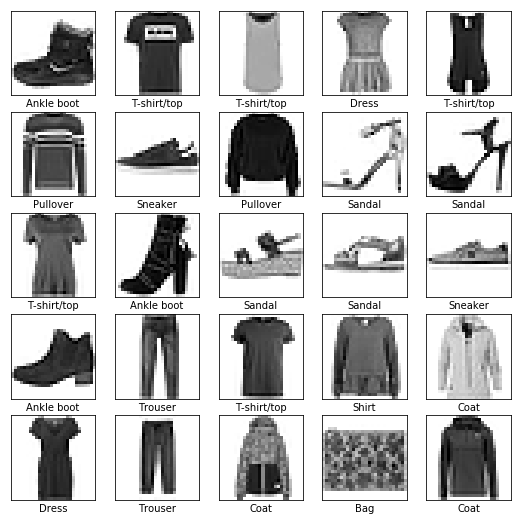

In [7]:
plt.figure(figsize=(9,9))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

- - -
## 2. CONSTRUCTION PHASE

In this section, I define at least three neural networks with different structures. Making sure that the input layer has the right number of inputs. The best structure often is found through a process of trial and error experimentation.

Neural networks 


**Important Implementation Note:** For the purpose of learning Tensorflow, I am using low-level TensorFlow API to construct the network. Usage of high-level tools (ie. Keras) will not be implemented in this experiment.

In [8]:
# These parameters are global across models
n_inputs = 28*28  # image dimensions
n_outputs = 10 # total of 10 fashion items


# shuffle_batch() shuffle the examples in a batch before training
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# flatten
X_train_raw = train_images.reshape(len(train_images), n_inputs)
y_train = train_labels
X_test_raw = test_images.reshape(len(test_images), n_inputs)
y_test = test_labels


# use standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_raw)

X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# spilt training into validation and training
X_val = X_train[:10000, :]
X_train = X_train[10000:, :]

y_val = y_train[:10000]
y_train = y_train[10000:]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### First model

The first model will be very basic, 300 neurons for the first layer and 130 for the second with no dropouts and using the Xavier initializer. The optimizer will be gradient descent for training the network.

**Neural networks**, or multilayer perceptrons, contain nodes with a linear relationship and some activation function. For example, a node from the first hidden layer takes all the inputs from the input layer and passes through some activation function before their signal is transmitted to the neurons in the next layer. For example, each node gets all the inputs from the layer before it denoted by $x$ and multiplies them by some weight $W$ and adds a bias term $b$, then finally processes them through an activation function $a(z)$ which decides the final output of that node.

$$z^{[l]}_{i}=x^{[l]}_{i}X^{[l]}+b^{[l]}_{i}$$

$$A^{[l]}_{i} = \sigma(z^{[l]}_{i})$$


> ![Neural Network](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41467-018-06322-x/MediaObjects/41467_2018_6322_Fig2_HTML.png)

> [Photo credit](https://www.nature.com/articles/s41467-018-06322-x)



First model will contain two hidden layers and using the Xavier initializer with no dropouts or normalization.

Using Gradient Descent optimizer to train and Leaky ReLU for activation.

In [9]:
reset_graph() # reset model

learning_rate = 0.32
n_hidden1 = 300
n_hidden2 = 130

# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name = "hidden1", 
                              activation = tf.nn.leaky_relu,
                             kernel_initializer = tf.contrib.layers.xavier_initializer(seed=42))
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name = "hidden2", 
                              activation = tf.nn.leaky_relu,
                             kernel_initializer = tf.contrib.layers.xavier_initializer(seed=42))
    logits = tf.layers.dense(hidden2, n_outputs, name = "outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                             logits=logits)
    loss = tf.reduce_mean(xentropy, name = "loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



This is the excution phase, I am feeding 400 samples per batch and training the model 30 times (epochs). Validation and testing accuracy displayed for each epoch.

In [10]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# number of epochs and batch sizes
n_epochs = 30
batch_size = 400

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    
        print(epoch, "Validation Accuracy:", acc_val, "Test Accuracy:", acc_test)
    
    save_path = saver.save(sess, "./model_01.ckpt")

0 Validation Accuracy: 0.8557 Test Accuracy: 0.8483
1 Validation Accuracy: 0.8592 Test Accuracy: 0.846
2 Validation Accuracy: 0.8694 Test Accuracy: 0.8615
3 Validation Accuracy: 0.8754 Test Accuracy: 0.8654
4 Validation Accuracy: 0.8823 Test Accuracy: 0.8726
5 Validation Accuracy: 0.8733 Test Accuracy: 0.8701
6 Validation Accuracy: 0.8746 Test Accuracy: 0.8677
7 Validation Accuracy: 0.8766 Test Accuracy: 0.871
8 Validation Accuracy: 0.8838 Test Accuracy: 0.8747
9 Validation Accuracy: 0.8847 Test Accuracy: 0.8755
10 Validation Accuracy: 0.884 Test Accuracy: 0.8758
11 Validation Accuracy: 0.8868 Test Accuracy: 0.8832
12 Validation Accuracy: 0.8808 Test Accuracy: 0.872
13 Validation Accuracy: 0.8851 Test Accuracy: 0.8801
14 Validation Accuracy: 0.8942 Test Accuracy: 0.884
15 Validation Accuracy: 0.8911 Test Accuracy: 0.8806
16 Validation Accuracy: 0.8859 Test Accuracy: 0.8774
17 Validation Accuracy: 0.8895 Test Accuracy: 0.8835
18 Validation Accuracy: 0.8933 Test Accuracy: 0.8876
19 Valid

This is not bad but I can try to tune the parameters even more.

### Second model

For this model I am designing my own neuron layer to see if that is different than the dense layer. This might work but I am just testing to see what effects it might have.

I am also adding dropout layers and using a different initialization.

In [0]:
# this function defines a layer to be constructed

def neuron_layer(X, n_neurons, name, activation=None):
     with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b
        if activation:
            return activation(z)
        else:
            return z

In [0]:
reset_graph() # reset model

learning_rate = 0.35
n_hidden1 = 512
n_hidden2 = 205
n_hidden3 = 52

# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# This is the network layout
with tf.name_scope("dnn"):
    dropout0 = tf.contrib.layers.dropout(X, keep_prob=0.9)

    hidden1 = neuron_layer(dropout0, n_hidden1, name = "hidden1", 
                            activation = tf.nn.relu)
                           
    dropout1 = tf.contrib.layers.dropout(hidden1, keep_prob=0.75)

    hidden2 = neuron_layer(dropout1, n_hidden2, name = "hidden2", 
                            activation = tf.nn.relu)
    
    dropout2 = tf.contrib.layers.dropout(hidden1, keep_prob=0.65)
    
    hidden3 = neuron_layer(hidden2, n_hidden3, name = "hidden3", 
                            activation = tf.nn.relu)
    dropout3 = tf.contrib.layers.dropout(hidden3, keep_prob=0.7)
    
    logits = neuron_layer(dropout3, n_outputs, name = "outputs")

    
with tf.name_scope("loss"):
  # use softmax for multiclass output
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                             logits=logits)
    loss = tf.reduce_mean(xentropy, name = "loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# number of epochs and batch sizes
n_epochs = 30
batch_size = 400

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op,extra_update_ops], feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    
        print(epoch, "Validation Accuracy:", acc_val, "Test Accuracy:", acc_test)
    
    save_path = saver.save(sess, "./model_02.ckpt")

0 Validation Accuracy: 0.8058 Test Accuracy: 0.7977
1 Validation Accuracy: 0.8239 Test Accuracy: 0.8138
2 Validation Accuracy: 0.8289 Test Accuracy: 0.8159
3 Validation Accuracy: 0.8462 Test Accuracy: 0.8331
4 Validation Accuracy: 0.8541 Test Accuracy: 0.8467
5 Validation Accuracy: 0.8592 Test Accuracy: 0.8468
6 Validation Accuracy: 0.8581 Test Accuracy: 0.851
7 Validation Accuracy: 0.853 Test Accuracy: 0.8509
8 Validation Accuracy: 0.8646 Test Accuracy: 0.8577
9 Validation Accuracy: 0.8617 Test Accuracy: 0.8517
10 Validation Accuracy: 0.8622 Test Accuracy: 0.8535
11 Validation Accuracy: 0.8647 Test Accuracy: 0.8568
12 Validation Accuracy: 0.8639 Test Accuracy: 0.853
13 Validation Accuracy: 0.867 Test Accuracy: 0.8619
14 Validation Accuracy: 0.8731 Test Accuracy: 0.8619
15 Validation Accuracy: 0.8709 Test Accuracy: 0.8632
16 Validation Accuracy: 0.8767 Test Accuracy: 0.8666
17 Validation Accuracy: 0.8653 Test Accuracy: 0.8591
18 Validation Accuracy: 0.8733 Test Accuracy: 0.8634
19 Vali

This model does not seem to do much better. Perhaps the previous model with more tuning methods will help.

### Third model

For this one I am using even more hyperparameters, I have added batch normalization, and used He initializer instead of Xavier.

I have chosen a different number of neurons per dense layer.

Also I have adjusted the momentum to 0.95 and opted for the Adagrad optimizer. 

In [0]:
reset_graph() # reset model

learning_rate = 0.34
n_hidden1 = 500
n_hidden2 = 200
momentum = 0.95

# Construct placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape = (), name = 'training')

# This is the network layout
with tf.name_scope("dnn"):
    bn0 = tf.layers.batch_normalization(X, training=training, momentum=momentum)
    dropout0 = tf.contrib.layers.dropout(bn0, keep_prob = 0.8)
    
    hidden1 = tf.layers.dense(dropout0, n_hidden1, name = "hidden1", 
                              kernel_initializer = tf.contrib.layers.variance_scaling_initializer(seed = 42))
    
    bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=momentum)
    bn1_act = tf.nn.leaky_relu(bn1)
    dropout1 = tf.contrib.layers.dropout(bn1_act, keep_prob=0.7)
    
    # 2nd layer
    hidden2 = tf.layers.dense(dropout1, n_hidden2, name = "hidden2", 
                              kernel_initializer = tf.contrib.layers.variance_scaling_initializer(seed = 42))
    
    bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=momentum)
    bn2_act = tf.nn.leaky_relu(bn2)
    dropout2 = tf.contrib.layers.dropout(bn2_act, keep_prob=0.65)
    
    
    #output layer
    logits_before_bn = tf.layers.dense(dropout2, n_outputs, name = "outputs")
    logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=momentum)

    
with tf.name_scope("loss"):
  # use softmax for multiclass output
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name = "loss")

with tf.name_scope("train"):
    # use AdagradOptimizer
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# number of epochs and batch sizes
n_epochs = 30
batch_size = 400

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], 
                     feed_dict={training: True, X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    
        print(epoch, "Validation Accuracy:", acc_val, "Test Accuracy:", acc_test)
    
    save_path = saver.save(sess, "./model_03.ckpt")

0 Validation Accuracy: 0.8217 Test Accuracy: 0.8165
1 Validation Accuracy: 0.84 Test Accuracy: 0.8269
2 Validation Accuracy: 0.8497 Test Accuracy: 0.8381
3 Validation Accuracy: 0.8506 Test Accuracy: 0.8402
4 Validation Accuracy: 0.8581 Test Accuracy: 0.842
5 Validation Accuracy: 0.8534 Test Accuracy: 0.8466
6 Validation Accuracy: 0.8593 Test Accuracy: 0.8468
7 Validation Accuracy: 0.8605 Test Accuracy: 0.8507
8 Validation Accuracy: 0.8596 Test Accuracy: 0.8547
9 Validation Accuracy: 0.8668 Test Accuracy: 0.8564
10 Validation Accuracy: 0.8653 Test Accuracy: 0.8524
11 Validation Accuracy: 0.8678 Test Accuracy: 0.8544
12 Validation Accuracy: 0.8658 Test Accuracy: 0.8583
13 Validation Accuracy: 0.8678 Test Accuracy: 0.8621
14 Validation Accuracy: 0.8692 Test Accuracy: 0.861
15 Validation Accuracy: 0.8695 Test Accuracy: 0.863
16 Validation Accuracy: 0.8703 Test Accuracy: 0.8634
17 Validation Accuracy: 0.8721 Test Accuracy: 0.8619
18 Validation Accuracy: 0.8712 Test Accuracy: 0.8622
19 Valid

In [19]:
with tf.Session() as sess:
    saver.restore(sess, "./model_03.ckpt")
    final_acc = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print('The final accuracy for my final model is:', final_acc*100, '%')

The final accuracy for my final model is: 86.59999966621399 %


With further tuning I might be able to bring the accuracy to 90% or higher. This is fairly difficult since I do not know the exact parameters that make this network optimal. Also, this network is using the low level API instead of high level like Keras. The purpose of this is to practice with low level and see if I can make working models without using optimal parameters.

---

In the future I will attempt to build more networks and tune the parameters even more to see if I can master the art of network construction. Also, in the future I will use convolutional neural nets (CNNs) to see how they impact performance.